## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP3_NAME1_NAME2` (or `SL_TP3_NAME` if you work alone).

**Deadline: January 30, 11:59 AM CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/Bandit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
    print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
    # install rlberry library
    !pip install scipy rlberry

In [2]:
import numpy as np
import random as rd
import scipy.stats as st
import gymnasium as gym
from matplotlib import pyplot as plt
import time

rng = np.random.default_rng(45161641614384786754156467846542343184353443258463569)

# Bandits

Bandits can be seen as RL with only one state. A bandit environment with $K$ actions (or arms) is parametrized by $K$ distributions $\nu_1, \ldots, \nu_K$ with finite means $\mu_1, \ldots, \mu_K$. At each time $t \in \mathbb{N}$, an agent
- chooses an arm $A_t \in \{1, \ldots, K\}$ (possibly based on previous observations)
- gets a reward $X_{A_t, t} \sim \nu_{A_t}$ samples from the distribution of arm $A_t$

In the regret minimization setting, the agent seeks to minimize its expected regret at some horizon $T$,
$$R_T = T \max_k \mu_k - \sum_{t = 1}^T \mu_{A_t} \: .$$

More precisely, we will evaluate agents/algorithms based on their expected regret $\mathbb{E}[R_T]$.

**Implement a function that computes the regret of a sequence of actions**

The result will be an array of length T = len(actions) containing the values of $R_t$ for all $t < T$.

In [17]:
def regret(means, actions):
    """
    Compute the regret of a sequence of actions on a bandit problem with given means

    means: numpy.ndarray; vector of means of the arm distributions, of size K
    actions: list of int in 0, ..., K-1; sequence of actions

    Returns: numpy.ndarray; regret of the sequence of actions at each time t <= len(actions)
    """
    
    best_mean = np.max(means)
    
    cumulative_regret = 0
    Rt = []
    
    # 2. On parcourt les actions jouées une par une
    for action in actions:
        # Perte instantanée = (Ce que j'aurais pu gagner) - (Ce que j'ai gagné en moyenne)
        instant_regret = best_mean - means[action]
        
        # On ajoute ça au sac
        cumulative_regret += instant_regret
        Rt.append(cumulative_regret)
    
    return np.array(Rt)
        

### Bandit environments

We will test our bandits algorithms on Gaussian distributions with variance 1 and on Bernoulli distributions.

In [3]:
class Bandit:
    def __init__(self, distrib):
        self.distributions = distrib
        self.means = [dist.mean() for dist in distrib]

    def sample(self, arm, n=1):
        # return n samples from one arm distribution, as a numpy array
        return self.distributions[arm].rvs(n)

class GaussianBandit(Bandit):
    def __init__(self, means):
        distrib = [st.norm(loc=m) for m in means]
        super().__init__(distrib) 

class BernoulliBandit(Bandit):
    def __init__(self, means):
        distrib = [st.bernoulli(p=m) for m in means]
        super().__init__(distrib) 

Example:

In [4]:
mu = np.array([0.3, 0.5, 0.25])
K = len(mu)
B1 = GaussianBandit(mu)
B2 = BernoulliBandit(mu)
print(B1.sample(2, 10))  # 10 samples of arm 2 in bandit B1
print(B1.means[2])  # mean of arm 2 in bandit B1
print(B2.sample(2))  # 1 sample of arm 2 in bandit B2
print(B2.means[2])  # mean of arm 2 in bandit B2

[ 0.03809719  0.93898231  0.99895955  2.22132045 -0.17801774 -0.26035009
 -0.87196169 -0.58968984 -1.32697741  1.29709314]
0.25
[1]
0.25


# Failure of Follow-The-Leader

The Follow-The-Leader algorithm (FTL) for bandits pulls each arm once and then pulls at each time the arm with highest empirical mean. That is, it pulls
$$
A_t = \arg\max_a \hat{\mu}_{t,a}
$$
where $\hat{\mu}_{t,a} = \frac{1}{N_{t,a}}\sum_{s=1}^{t-1} X_{A_s, s} \mathbb{I}\{A_s = a\}$ and $N_{t,a} = \sum_{s=1}^{t-1} \mathbb{I}\{A_s = a\}$.

**What is in general the dependence in the horizon $T$ of the expected regret of FTL?**

#TODO answer here

**Implement the Follow-The-Leader algorithm**

In general, a bandit algorithm uses the whole sequence of past interactions to decide which arm should be pulled next. However, all algorithm we will implement in this notebook are functions of the number of past pulls of the arms and their empirical means, as well as the current time. 

In [7]:
def FTL(emp_means, nb_pulls, t):
    """
    Follow-The-Leader arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by FTL
    """
    
    max_mean = np.max(emp_means)

    candidates = np.where(emp_means == max_mean)[0]

    action = np.random.choice(candidates)

    return action




**Plot the mean regret of FTL on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

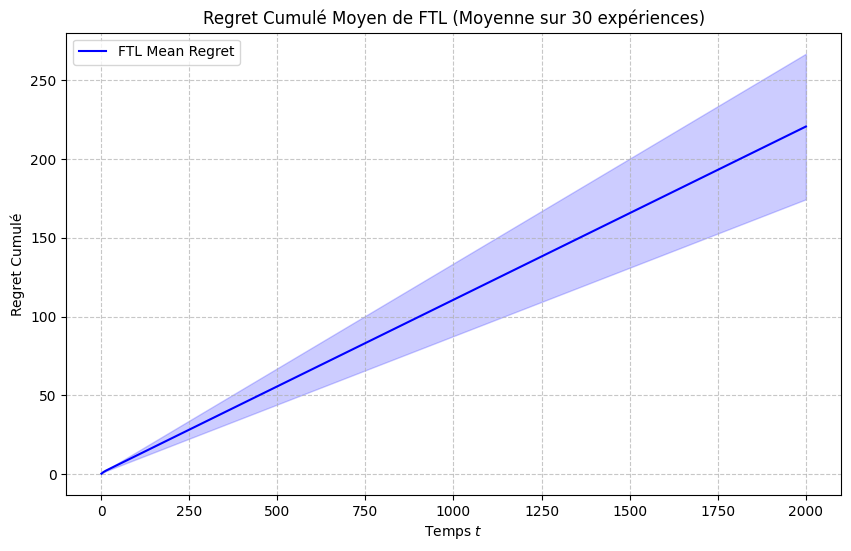

In [ ]:
T = 2000
N = 30
means = [0.3, 0.5, 0.25, 0.1]

all_regrets = np.zeros((N, T))

for i in range(N):
    # Initialisation du Bandit
    bandit = GaussianBandit(means)
    K = len(means)
    
    # Mémoire de l'agent
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    sum_rewards = np.zeros(K)
    actions_history = []
    
    for t in range(T):
        # 1. Décision
        action = FTL(emp_means, nb_pulls, t)
        actions_history.append(action)
        
        # 2. Observation (Reward)
        reward = bandit.sample(action)[0]
        
        # 3. Mise à jour des stats
        nb_pulls[action] += 1
        sum_rewards[action] += reward
        emp_means[action] = sum_rewards[action] / nb_pulls[action]
    
    # Calcul du regret pour cette expérience une fois terminée
    all_regrets[i, :] = regret(bandit.means, actions_history)

# --- 5. Affichage ---
mean_regret = np.mean(all_regrets, axis=0)
std_regret = np.std(all_regrets, axis=0)
# Erreur standard pour l'intervalle de confiance
ste_regret = std_regret / np.sqrt(N)

plt.figure(figsize=(10, 6))
x_axis = range(1, T + 1)

# Courbe moyenne
plt.plot(x_axis, mean_regret, label='FTL Mean Regret', color='blue')

# Zone d'ombre (Intervalle de confiance)
plt.fill_between(x_axis, 
                 mean_regret - ste_regret, 
                 mean_regret + ste_regret, 
                 color='blue', alpha=0.2)

plt.xlabel('Temps $t$')
plt.ylabel('Regret Cumulé')
plt.title(f'Regret Cumulé Moyen de FTL (Moyenne sur {N} expériences)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Look at several individual runs of FTL (in particular look at the sequence of actions). How can we explain the bad expected regret of FTL?**

# TODO

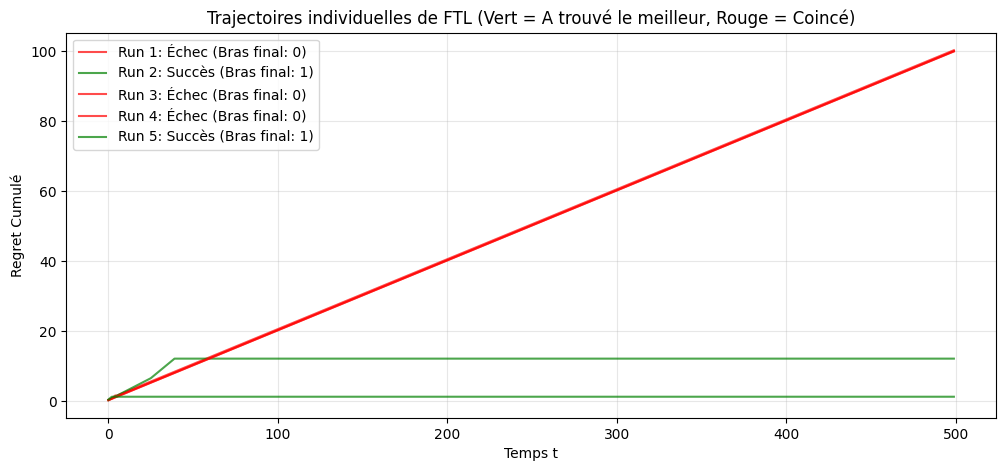

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Paramètres
means = [0.3, 0.5, 0.25, 0.1] # Le meilleur est l'indice 1 (0.5)
best_arm_index = 1
T = 500 # On réduit un peu T pour la lisibilité
N_runs_to_show = 5

plt.figure(figsize=(12, 5))

for i in range(N_runs_to_show):
    bandit = GaussianBandit(means)
    emp_means = np.zeros(len(means))
    nb_pulls = np.zeros(len(means))
    sum_rewards = np.zeros(len(means))
    actions = []
    
    # Pour stocker le regret de CE run
    run_regret = []
    cumulative_r = 0
    best_mean = max(means)

    for t in range(T):
        action = FTL(emp_means, nb_pulls, t)
        actions.append(action)
        
        # Reward & Update
        reward = bandit.sample(action)[0]
        nb_pulls[action] += 1
        sum_rewards[action] += reward
        emp_means[action] = sum_rewards[action] / nb_pulls[action]
        
        # Calcul regret
        cumulative_r += (best_mean - means[action])
        run_regret.append(cumulative_r)

    # Affichage du run
    # On regarde si à la fin il jouait le bon bras ou non
    final_arm = actions[-1]
    status = "Succès" if final_arm == best_arm_index else "Échec"
    color = "green" if final_arm == best_arm_index else "red"
    
    plt.plot(run_regret, label=f'Run {i+1}: {status} (Bras final: {final_arm})', color=color, alpha=0.7)

plt.xlabel('Temps t')
plt.ylabel('Regret Cumulé')
plt.title('Trajectoires individuelles de FTL (Vert = A trouvé le meilleur, Rouge = Coincé)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# $\varepsilon$-greedy

In order to obtain sub-linear regret, an algorithm should balance *exploration* and *exploitation*. The $\varepsilon$-greedy algorithm selects with probability $\varepsilon$ an arm uniformly at random (exploration) and with probability $1 - \varepsilon$ it chooses the empirical best arm like FTL.

**Implement $\varepsilon$-greedy for a decreasing $\varepsilon_t = c/t$, where $c$ is a parameter and $t$ is the current time.**

In [28]:
def eps_greedy(emp_means, nb_pulls, t):
    """
    eps-greedy arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by eps-greedy
    """
    K = len(emp_means)
    c = 2

    if t == 0:
        eps_t = 1.0
    else:
        eps_t = min(1.0, c / t)
    

    

    if np.random.random() < eps_t:
        action = np.random.choice(K)
    else: 
        max_mean = np.max(emp_means)
        candidates = np.where(emp_means == max_mean)[0]
        action = np.random.choice(candidates)
    return action

# UCB

The UCB algorithm is optimistic: it selects the arm with highest upper confidence bound. Using concentration of measure arguments, we can construct confidence intervals on the means of each arm, such that the true mean belongs to the interval with large enough probability. UCB then selects the arm with highest upper bound for the confidence interval.

The algorithm starts by pulling all arms: $A_t = t$ for $t \le K$. Then, using a confidence interval obtained from a 1-sub-Gaussian assumption, UCB selects

$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{2 \log t}{N_{t,a}}} \: .$$



**Implement the UCB algorithm**

In [34]:
def UCB(emp_means, nb_pulls, t):
    """
    UCB arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by UCB
    """
    K = len(emp_means)
    for arm in range(K):
        if nb_pulls[arm] == 0:
            return arm
    
    bonus = np.sqrt((2 * np.log(t)) / nb_pulls)
    ucb_values = emp_means + bonus
    action = np.argmax(ucb_values)
    
    return action

**Plot the mean regret of FTL, $\varepsilon_t$-greedy and UCB on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

See the lecture notes for a good theoretical choice of the parameter $c$ in $\varepsilon_t$-greedy.

In [23]:
def run_experiment(algo_func, bandit, T, **kwargs):
    K = len(bandit.means)
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    sum_rewards = np.zeros(K)
    actions = []
    
    for t in range(T):
        # Appel de l'algo (certains ont besoin de kwargs comme c)
        action = algo_func(emp_means, nb_pulls, t, **kwargs)
        actions.append(action)
        
        # Reward
        reward = bandit.sample(action)[0]
        
        # Update
        nb_pulls[action] += 1
        sum_rewards[action] += reward
        emp_means[action] = sum_rewards[action] / nb_pulls[action]
        
    return np.array(actions)

Simulation en cours...


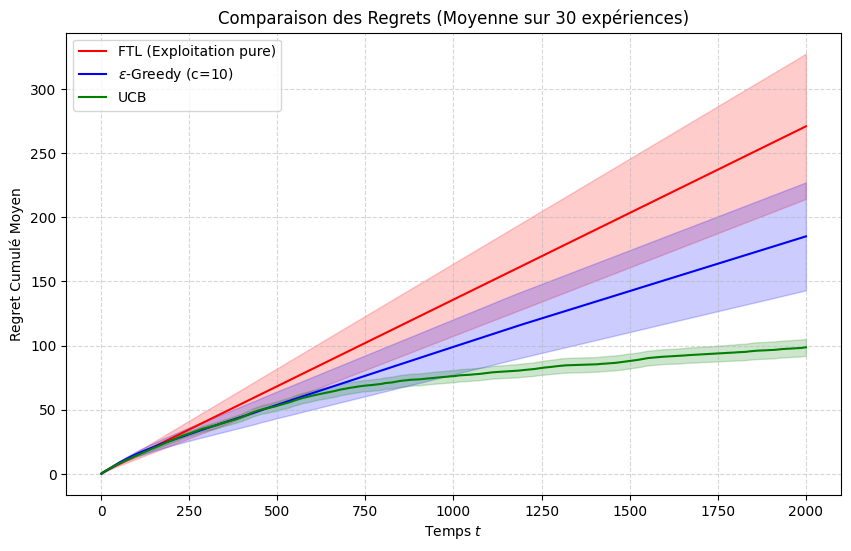

In [35]:
means = [0.3, 0.5, 0.25, 0.1]
T = 2000
N_experiments = 30

# Stockage des résultats
regrets_ftl = np.zeros((N_experiments, T))
regrets_eps = np.zeros((N_experiments, T))
regrets_ucb = np.zeros((N_experiments, T))

print("Simulation en cours...")

for i in range(N_experiments):
    bandit = GaussianBandit(means)
    
    # 1. Run FTL
    actions_ftl = run_experiment(FTL, bandit, T)
    regrets_ftl[i, :] = regret(np.array(means), actions_ftl)
    
    # 2. Run Eps-Greedy (avec c=10 pour bien explorer au début)
    # Note: On passe c via une lambda ou wrapper si besoin, ici adapté dans la boucle
    actions_eps = run_experiment(lambda em, np, t: eps_greedy(em, np, t), bandit, T)
    regrets_eps[i, :] = regret(np.array(means), actions_eps)
    
    # 3. Run UCB
    actions_ucb = run_experiment(UCB, bandit, T)
    regrets_ucb[i, :] = regret(np.array(means), actions_ucb)

# --- PLOTTING ---

plt.figure(figsize=(10, 6))

# Fonction d'aide pour tracer courbe + ombre
def plot_with_conf(data, label, color):
    mean = np.mean(data, axis=0)
    ste = np.std(data, axis=0) / np.sqrt(N_experiments)
    plt.plot(range(1, T+1), mean, label=label, color=color)
    plt.fill_between(range(1, T+1), mean-ste, mean+ste, color=color, alpha=0.2)

plot_with_conf(regrets_ftl, 'FTL (Exploitation pure)', 'red')
plot_with_conf(regrets_eps, '$\epsilon$-Greedy (c=10)', 'blue')
plot_with_conf(regrets_ucb, 'UCB', 'green')

plt.xlabel('Temps $t$')
plt.ylabel('Regret Cumulé Moyen')
plt.title(f'Comparaison des Regrets (Moyenne sur {N_experiments} expériences)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Comment on the graph. What is the dependence in $T$ of the regret of UCB?**

#TODO answer here

Consider the following variant UCB(c), which takes a parameter $c>0$,
$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{c \log t}{N_{t,a}}} \: .$$

**Implement UCB(c) and plot the regret of UCB(c) for varying values of $c$, first for the Gaussian bandit, then for a Bernoulli bandit with same means. Discuss.**

In [37]:
def UCB_c(emp_means, nb_pulls, t, c):
    """
    UCB arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by UCB
    """
    K = len(emp_means)
    for arm in range(K):
        if nb_pulls[arm] == 0:
            return arm
    
    bonus = np.sqrt((c * np.log(t)) / nb_pulls)
    ucb_values = emp_means + bonus
    action = np.argmax(ucb_values)
    
    return action

--- Gaussian Bandit ---
Simulation pour c = 0.1...
Simulation pour c = 0.5...
Simulation pour c = 2...
Simulation pour c = 5...

--- Bernoulli Bandit ---
Simulation pour c = 0.1...
Simulation pour c = 0.5...
Simulation pour c = 2...
Simulation pour c = 5...


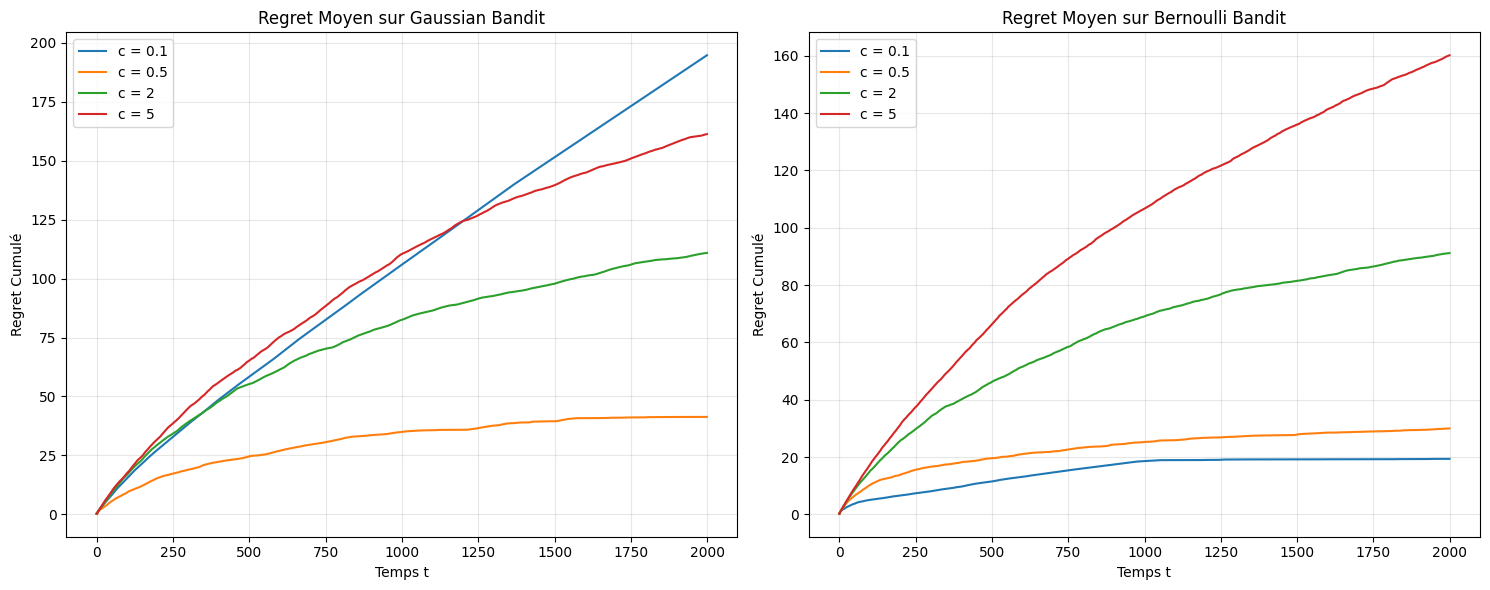

In [39]:
def run_simulation(bandit_class, means, c_values, T, N_experiments):
    results = {}
    
    for c in c_values:
        print(f"Simulation pour c = {c}...")
        regrets = np.zeros((N_experiments, T))
        
        for i in range(N_experiments):
            bandit = bandit_class(means)
            K = len(means)
            emp_means = np.zeros(K)
            nb_pulls = np.zeros(K)
            sum_rewards = np.zeros(K)
            actions = []
            
            for t in range(1, T + 1): # t commence à 1 pour log(t)
                # Décision
                action = UCB_c(emp_means, nb_pulls, t, c)
                actions.append(action)
                
                # Reward
                reward = bandit.sample(action)[0]
                
                # Update
                nb_pulls[action] += 1
                sum_rewards[action] += reward
                emp_means[action] = sum_rewards[action] / nb_pulls[action]
            
            # Calcul du regret pour ce run
            # On passe actions qui est une liste, numpy fera l'indexation
            regrets[i, :] = regret(np.array(means), np.array(actions))
            
        # Moyenne sur les N expériences
        results[c] = np.mean(regrets, axis=0)
        
    return results

# --- 5. Exécution et Affichage ---

# Paramètres
means = [0.3, 0.5, 0.25, 0.1]
T = 2000
N = 30
c_values = [0.1, 0.5, 2, 5] # On teste différentes intensités d'exploration

# A. Simulation Gaussian
print("--- Gaussian Bandit ---")
res_gaussian = run_simulation(GaussianBandit, means, c_values, T, N)

# B. Simulation Bernoulli
print("\n--- Bernoulli Bandit ---")
res_bernoulli = run_simulation(BernoulliBandit, means, c_values, T, N)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1 : Gaussian
for c, curve in res_gaussian.items():
    axes[0].plot(curve, label=f'c = {c}')
axes[0].set_title('Regret Moyen sur Gaussian Bandit')
axes[0].set_xlabel('Temps t')
axes[0].set_ylabel('Regret Cumulé')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Bernoulli
for c, curve in res_bernoulli.items():
    axes[1].plot(curve, label=f'c = {c}')
axes[1].set_title('Regret Moyen sur Bernoulli Bandit')
axes[1].set_xlabel('Temps t')
axes[1].set_ylabel('Regret Cumulé')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Thompson Sampling

The Thompson Sampling (TS) algorithm takes a Bayesian approach (even though the regret metric is a frequentist way of evaluating an algorithm).

The algorithm postulates a prior distribution for the means of the arms, say a Gaussian $\mathcal{N}(0,1)$. Then after each pull, it updates the posterior distribution of the mean of each arm.

After $N_{t,a}$ observations sampled from a Gaussian distribution with variance 1, with average reward $\hat{\mu}_{t,a}$, arm $a$ has posterior distribution $P_{a,t} = \mathcal N(\hat{\mu}_{t,a} \frac{N_{t,a}}{N_{t,a} + 1}, \frac{1}{N_{t,a} + 1})$.

At time $t$, the algorithm then samples the posterior distribution of each arm, and pulls the arm with highest sample. That is, it samples $\theta_{a,t} \sim P_{a,t}$ for all $a \in [K]$, then samples $A_t = \arg\max_a \theta_{a,t}$.

**Implement Gaussian Thompson Sampling**

In [ ]:
def TS(emp_means, nb_pulls, t):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by TS
    """
    #TODO

**Plot the regret of Gaussian TS and UCB on the Gaussian bandit from previous questions, as well as on a Bernoulli bandit with same means. Discuss.**

Thompson sampling can be adapted to the reward distributions by changing the prior: if the rewards are Gaussian, a Gaussian prior makes sense and leads to a Gaussian posterior. If the rewards are Bernoulli, we can use a uniform prior, which leads to a Beta posterior (see lecture 6 for the precise parameters of the Beta posterior).

**Implement TS with uniform prior and Beta posterior**

In [ ]:
def TS_beta(emp_means, nb_pulls, t):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by TS
    """
    #TODO

**On a Gaussian bandit, compare the regret of TS with Gaussian posterior, TS with Beta posterior, and UCB.**

(note that even though the Beta is a true posterior for the uniform prior only for Benoulli rewards, we can still run the algorithm on Gaussian rewards while pretending that the Beta is a posterior, and see what happens)

In [ ]:
#TODO

**On a Bernoulli bandit, compare the regret of TS with Gaussian prior, TS with Beta posterior, and UCB.**

In [ ]:
#TODO

**How could the UCB algorithm be improved to have a lower regret on Bernoulli bandits, if we know beforehand that the distributions are Bernoulli?**

#TODO